# Pairwise distances between individuals within each population

In [1]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

numpy.random.seed(7)

### Analysis dirs

In [2]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
#argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
#dist_dir = steps_dir / 'dist_stores'
#male_x_haploid_dir = steps_dir / 'male_x_haploids'

### Local code in the scripts dir on the cluster

In [3]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

### Convenience functions

In [4]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)

### Plotting setup

In [5]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'retina')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import UnivariateSpline

### Hide deprecation warnings

Run this only after importing modules

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

# Load meta data

In [7]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

Distribution of the two sexes in each population:

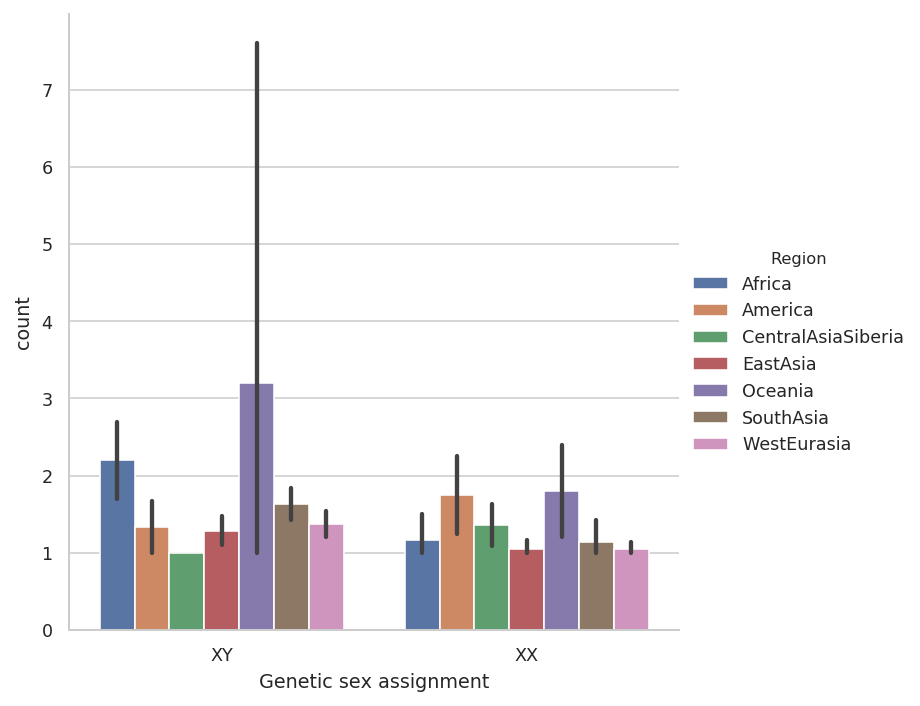

In [8]:
df = DataFrame.from_dict(individuals, orient='index')
df = (df.loc[:, ['Genetic sex assignment', 'Population ID', 'Region']]
        .groupby(['Region', 'Population ID', 'Genetic sex assignment'])
        .aggregate('size')
        .to_frame(name='count')
        .reset_index()
      ) 

# ax = sns.factorplot(x="Genetic sex assignment", y="count", hue="Population ID", 
#                     col='Region', data=df, kind="bar", sharex=False)

ax = sns.catplot(x="Genetic sex assignment", y="count", hue="Region", 
                    data=df, kind="bar", sharex=False)

g = plt.savefig(str(figures_dir / "region_sex_counts.pdf"))

In [9]:
DataFrame.from_dict(individuals, orient='index')['Population ID'].value_counts()


Papuan            15
Dai                4
Mbuti              4
Ju_hoan_North      4
Punjabi            4
French             3
Even               3
Sardinian          3
Yoruba             3
Han                3
Mandenka           3
Dinka              3
Mixe               3
Jordanian          3
Quechua            3
Karitiana          3
Japanese           3
Iraqi_Jew          2
Icelandic          2
Brahui             2
Greek              2
Mayan              2
Korean             2
She                2
Yadava             2
Georgian           2
Sindhi             2
Tajik              2
Kapu               2
Armenian           2
                  ..
Tu                 2
Tubalar            2
Bergamo            2
Bulgarian          2
Druze              2
Tuscan             2
Yi                 2
English            2
Balochi            2
Adygei             2
BedouinB           2
Saami              2
Polish             1
Lezgin             1
Finnish            1
Maori              1
Hawaiian     

# Load pi data

We load pi data for chrX and for chr7 to represent an autosome of similar size. 

In [10]:
# only chr7
pi_data_chr7 = pandas.read_hdf(str(pi_dir / 'pi_data_chr7_100kb.store'), 'df')

Since males are haploid for chrX, we need to remove pi data (rows) for individuals where an individual is male and its B pseudohaplod is used.

In [11]:
# # only chrX
# pi_data_chrX = (pandas.read_hdf(str(pi_dir / 'pi_data_chrX_100kb.store'), 'df')
#                 .query('not ((sex_1 == "XY" & pseud_1 == "B") | (sex_2 == "XY" & pseud_2 == "B"))')
#                )

We only want the females for X so the comparison with other chormosomess is not affected by phasing:

In [12]:
# only chrX
pi_data_chrX = (pandas.read_hdf(str(pi_dir / 'pi_data_chrX_100kb.store'), 'df')
                .query('(sex_1 == "XX") & (sex_2 == "XX")')
               )


#pi_data_chrX = pi_data_chrX.loc[(pi_data_chrX.sex_1 == 'XX') & (pi_data_chrX.sex_2 == 'XX')]

Remove excluded indivduals:

In [13]:
pi_data_chrX = pi_data_chrX.loc[(pi_data_chrX.indiv_1.isin(list(individuals.keys()))) & (pi_data_chrX.indiv_2.isin(list(individuals.keys())))]

pi_data_chr7 = pi_data_chr7.loc[(pi_data_chr7.indiv_1.isin(list(individuals.keys()))) & (pi_data_chr7.indiv_2.isin(list(individuals.keys())))]

Get geo-location of individuals in each population

In [14]:
# compute center location for individuals from each population
indiv_locations = dict()
missing_member_pops = set()
for pop in populations:
    for indiv in populations[pop]:
        lat = individuals[indiv]['Latitude']
        long = individuals[indiv]['Longitude']
        if math.isnan(lat) or math.isnan(long):
            print("skipping coords for", pop, 
                  individuals[indiv]['Latitude'], individuals[indiv]['Longitude'])
            missing_member_pops.add(pop)
            continue
        if pop not in indiv_locations:
            indiv_locations[pop] = []
        indiv_locations[pop].append((lat, long))

# make sure at least one individual represents the 
# populations where individuals are skipped
for pop in missing_member_pops:
    if pop not in indiv_locations:
        print("WARNING: no coord data for any individuals in", pop)

print('Manually adding center coordinates for Crete and Norway')
indiv_locations['Crete'] = [(35.2401, 24.8093)]
indiv_locations['Norwegian'] = [(60.4720, 8.4689)]
    

skipping coords for Australian nan nan
skipping coords for Crete nan nan
skipping coords for Crete nan nan
skipping coords for Balochi nan nan
skipping coords for Bergamo nan nan
skipping coords for Norwegian nan nan
Manually adding center coordinates for Crete and Norway


Add the center geo-location for each population.

In [15]:
def center_geo(latitudes, longitudes):
    lat_list, lon_list = list(latitudes), list(longitudes)
    x_list = [math.cos(lat * math.pi/180 ) * math.cos(lon * math.pi/180 ) \
              for lat, lon in zip(lat_list, lon_list)]
    y_list = [math.cos(lat * math.pi/180 ) * math.sin(lon * math.pi/180 ) \
              for lat, lon in zip(lat_list, lon_list)]
    z_list = [math.sin(lat * math.pi/180 ) for lat in lat_list]
    x = sum(x_list)/len(x_list)
    y = sum(y_list)/len(y_list)
    z = sum(z_list)/len(z_list)
    center_long = math.atan2(y, x)  * 180 / math.pi
    hyp = math.sqrt(x * x + y * y)
    center_lat = math.atan2(z, hyp)  * 180 / math.pi
    return center_lat, center_long
          
pop_locations = dict()
for pop, tup_list in indiv_locations.items():    
    pop_locations[pop] = center_geo(*zip(*tup_list))
    
    

Remove individuals that are excluded:

In [16]:
a = set(pop_locations.keys())
b = set(pi_data_chrX.pop_label.unique())
extra_excluded = list(b.difference(a))
extra_excluded

[]

In [17]:
pi_data_chrX.size

5466560

In [18]:
# pi_data_chrX = pi_data_chrX.loc[~pi_data_chrX.pop_label.isin(extra_excluded)]
# pi_data_chr7 = pi_data_chr7.loc[~pi_data_chr7.pop_label.isin(extra_excluded)]

In [19]:
pi_data_chrX.size

5466560

In [20]:
# add center coordinates for member population
pi_data_chrX['latitude_center'], pi_data_chrX['longitude_center'] = \
    zip(*(pop_locations[x] for x in pi_data_chrX.pop_label))
pi_data_chr7['latitude_center'], pi_data_chr7['longitude_center'] = \
    zip(*(pop_locations[x] for x in pi_data_chr7.pop_label))
    
# the Mixe populations have the wrong sign for their longitude in the meta file
# so we need to fix that here
print('Fixing sign on longitude for Mixe')
pi_data_chrX.loc[pi_data_chrX.population == 'Mixe', 'longitude_center'] *= -1


# write locations to results dir
with open(str(results_dir / 'pop_locations.pkl'), 'wb') as f:
    pickle.dump(pop_locations, f)

Fixing sign on longitude for Mixe


In [21]:
pi_data_chrX.to_hdf(results_dir / 'pi_data_chrX.hdf', 'df', format='table', mode='w')
pi_data_chr7.to_hdf(results_dir / 'pi_data_chr7.hdf', 'df', format='table', mode='w')


### Create a filtering mask

Distribution of number of uncalled bases across windows:

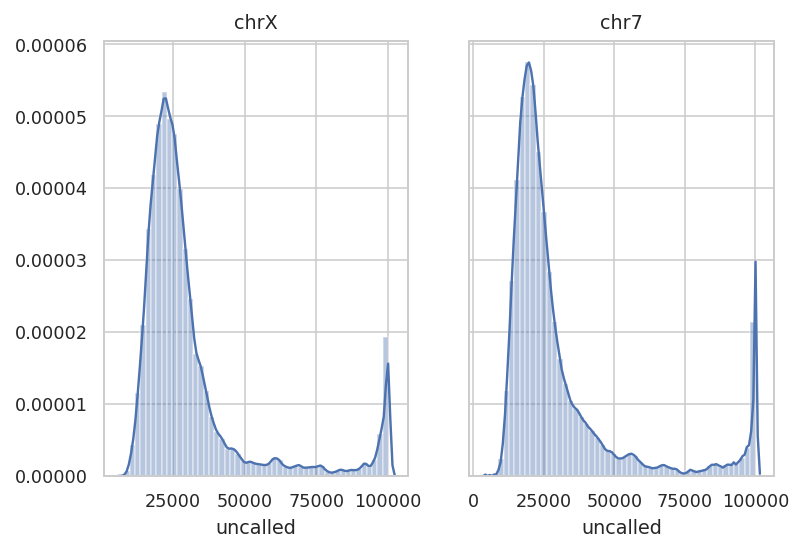

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax = sns.distplot(pi_data_chrX.uncalled, ax=ax1)
ax.set_title('chrX')
ax = sns.distplot(pi_data_chr7.uncalled, ax=ax2)
ax.set_title('chr7')
plt.savefig(str(figures_dir / "distr_uncalled_bases.pdf"))

We chose the following cutoff to mask windows from further analysis:

In [23]:
max_uncalled_bases = 50000
print("Max uncalled bases:", max_uncalled_bases)

Max uncalled bases: 50000


In [24]:
pi_filter_mask_chrX = numpy.array(pi_data_chrX.uncalled > max_uncalled_bases)
pi_filter_mask_chr7 = numpy.array(pi_data_chr7.uncalled > max_uncalled_bases)

with open(str(results_dir / 'pi_filter_mask_chrX.npy'), 'wb') as f:
    numpy.save(f, pi_filter_mask_chrX)
with open(str(results_dir / 'pi_filter_mask_chr7.npy'), 'wb') as f:
    numpy.save(f, pi_filter_mask_chr7)

### Intersect individulals in pi data with those in meta data

Three individuals were removed from the analysis: S_Palestinian-2, S_Naxi-2 and S_Jordanian-1. S_Naxi-2 was removed because it has a high heterozygosity on the X chromosome compared to other males. S_Palestinian-2 has a low heterozygosity on the X chromosome compared to other females, and has an X chromosome coverage comparable to males while having a Y chromosome coverage comparable to females. S_Jordanian-1 was removed because it is an outlier in all the copy number analysis. These three individuals had also been removed for some analysis in the SGDP paper for different reasons.

In addition, populations represented by only one individual are not included in the analysis.

In [25]:
df = DataFrame.from_dict(individuals, orient='index')
df = (df.loc[:, ['Genetic sex assignment', 'Population ID', 'Region']]
           .groupby(['Region', 'Population ID', 'Genetic sex assignment'])
        .aggregate('size')
        .to_frame(name='indiv_count')
         .reset_index()
        )

print("Nr of populations in data set:", len(pi_data_chrX.population.drop_duplicates()))
print()
print("Number of populations with at least one individual of a sex:")
print(df.groupby("Genetic sex assignment").size())
print()
# print("This is the one that does not have an assigned sex:")
# print(df.loc[df['Genetic sex assignment'] == 'Not Assigned'])
# print()

pops_with_males_meta = list(df.loc[df["Genetic sex assignment"] == 'XY']['Population ID'].drop_duplicates())
pops_pi = list(pi_data_chrX.population.drop_duplicates())

print("These are the populations missing from the pi data set because they only have one indiidual:")
print([(k, len(v)) for k, v in populations.items() if k not in pops_pi])
print()
print("These are the populations without male samples:")
print([(k, len(v)) for k, v in populations.items() if k not in pops_with_males_meta])


Nr of populations in data set: 16

Number of populations with at least one individual of a sex:
Genetic sex assignment
XX     77
XY    106
dtype: int64

These are the populations missing from the pi data set because they only have one indiidual:
[('Dinka', 3), ('Ju_hoan_North', 4), ('Mandenka', 3), ('Mbuti', 4), ('Yoruba', 3), ('Karitiana', 3), ('Han', 3), ('Australian', 2), ('Crete', 2), ('French', 3), ('Sardinian', 3), ('BantuHerero', 2), ('BantuTswana', 2), ('Biaka', 2), ('Esan', 2), ('Mende', 2), ('Chane', 1), ('Mixtec', 2), ('Pima', 2), ('Zapotec', 2), ('Aleut', 2), ('Altaian', 1), ('Chukchi', 1), ('Eskimo_Chaplin', 1), ('Eskimo_Sireniki', 2), ('Itelman', 1), ('Kyrgyz', 2), ('Mongola', 2), ('Tlingit', 2), ('Yakut', 2), ('Ami', 2), ('Atayal', 1), ('Burmese', 2), ('Cambodian', 2), ('Daur', 1), ('Hezhen', 2), ('Japanese', 3), ('Kinh', 2), ('Korean', 2), ('Lahu', 2), ('Miao', 2), ('Naxi', 2), ('Oroqen', 2), ('She', 2), ('Thai', 2), ('Tu', 2), ('Tujia', 2), ('Uygur', 2), ('Xibo', 2), (

# World map with population names

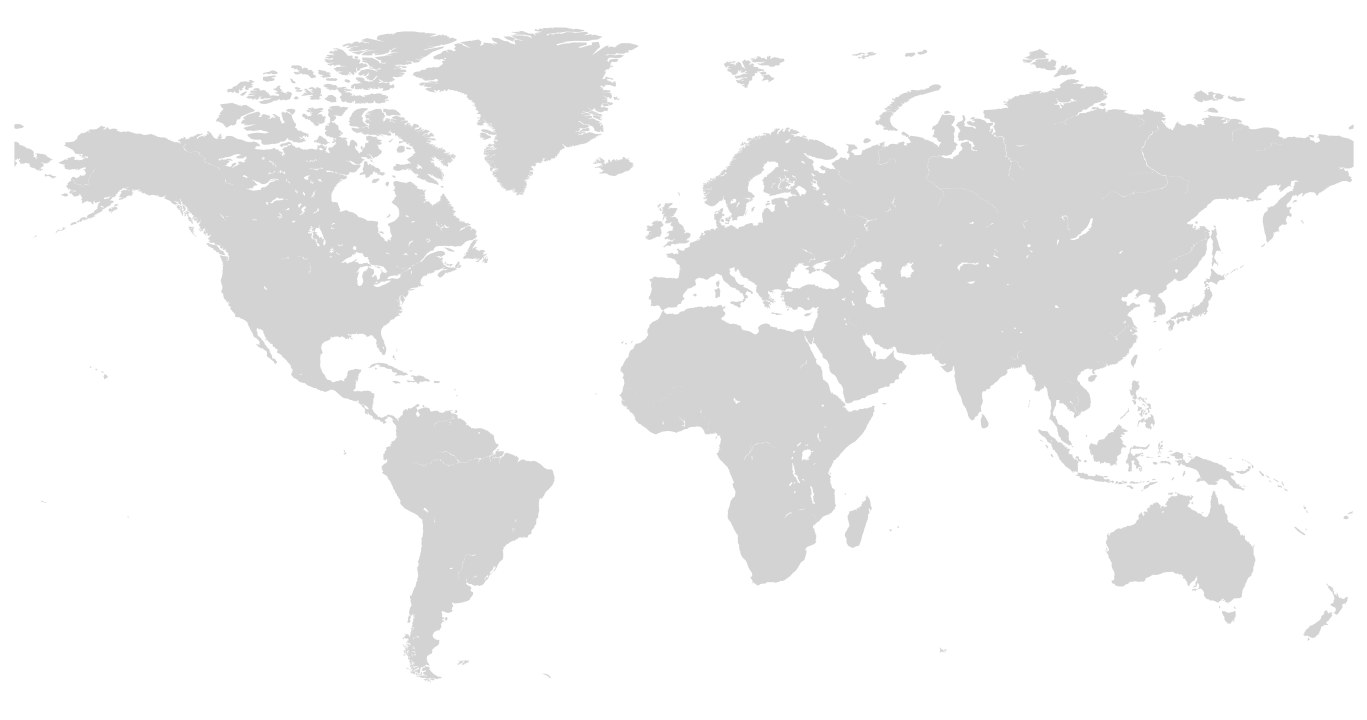

In [26]:
# empty world map for makeing figures on
plt.close()
with sns.color_palette("Set1", 7):

    fig = plt.figure(figsize=(12,8))
    # back to remove border around map
    ax = fig.add_subplot(111)
    ax.axis('off')

    m = Basemap(projection='mill',
                urcrnrlon=180, 
                urcrnrlat=85,
                llcrnrlon=-180,
                llcrnrlat=-60,
                resolution='l', # 'c' is crude, l is low, i is intermediate, h is high, f is full
                suppress_ticks=True)
    m.fillcontinents(color='lightgrey',lake_color='white', zorder=0)
#     m.drawcountries(linewidth=0.2, linestyle='solid', color='black', zorder=1)

    plt.savefig(str(figures_dir / "worldmap.pdf"))
#    plt.close() # closing the plot suppres automatic plotting without plt.show()

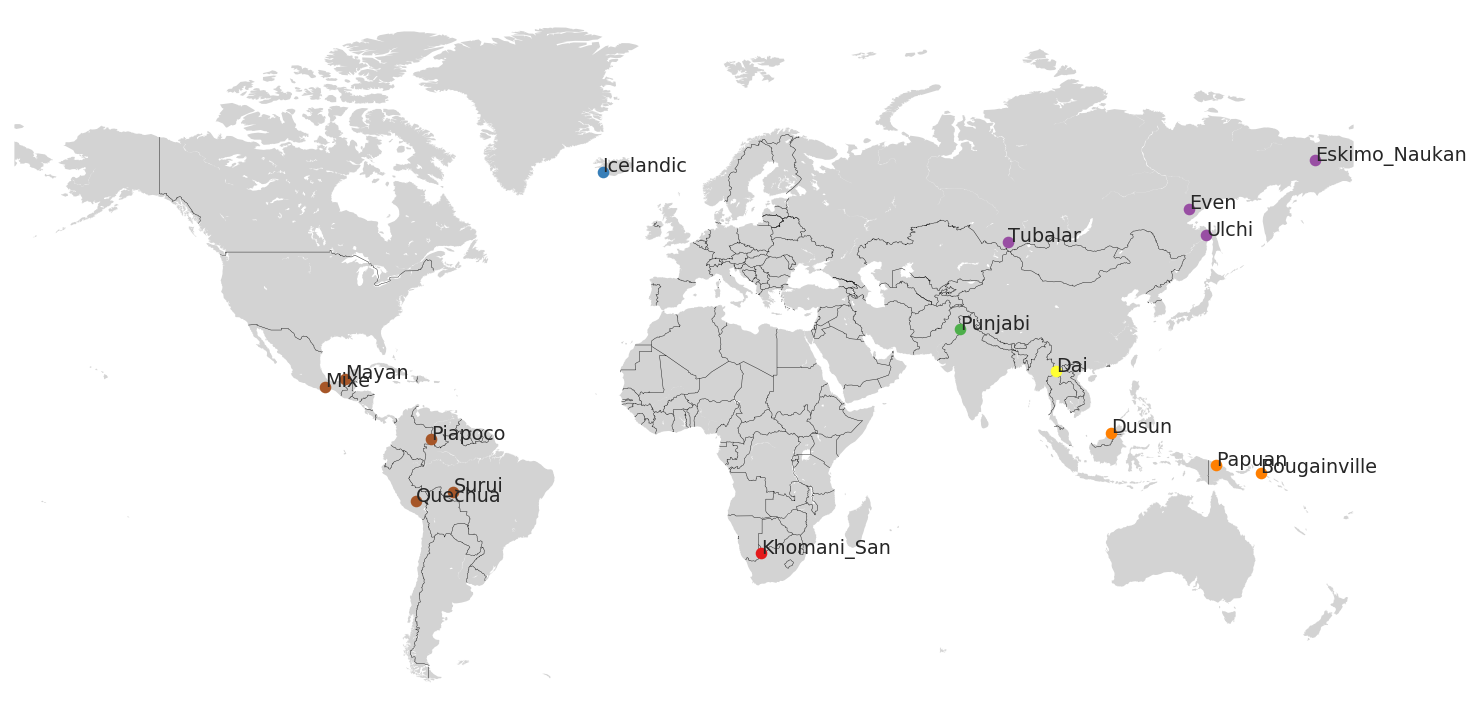

In [27]:
plt.close()
with sns.color_palette("Set1", 7):

    fig = plt.figure(figsize=(12,8))
    # back to remove border around map
    ax = fig.add_subplot(111)
    ax.axis('off')

    m = Basemap(projection='mill',
                urcrnrlon=180, 
                urcrnrlat=85,
                llcrnrlon=-180,
                llcrnrlat=-60,
                resolution='l', # 'c' is crude, l is low, i is intermediate, h is high, f is full
                suppress_ticks=True)
    m.fillcontinents(color='lightgrey',lake_color='white', zorder=0)
    m.drawcountries(linewidth=0.2, linestyle='solid', color='black', zorder=1)

    df = pi_data_chrX[['population', 'region', 'longitude_center', 'latitude_center']].drop_duplicates()

    xvals, yvals = zip(*[m(*p) for p in zip(df.longitude_center, df.latitude_center)])
    for x, y, lab in zip(xvals, yvals, df.population):
        plt.text(x, y, str(lab))
    
    groups = df.groupby('region')
    for name, group in groups:
        xvals, yvals = zip(*[m(*p) for p in zip(group.longitude_center, group.latitude_center)])
        m.plot(xvals, yvals, marker='o', linestyle='', label=name)
        
    #plt.legend(loc=3, fontsize=10)

    plt.savefig(str(figures_dir / "simons_labeled_worldmap.pdf"))
    
    plt.show()
    
#mpld3.display(fig)    


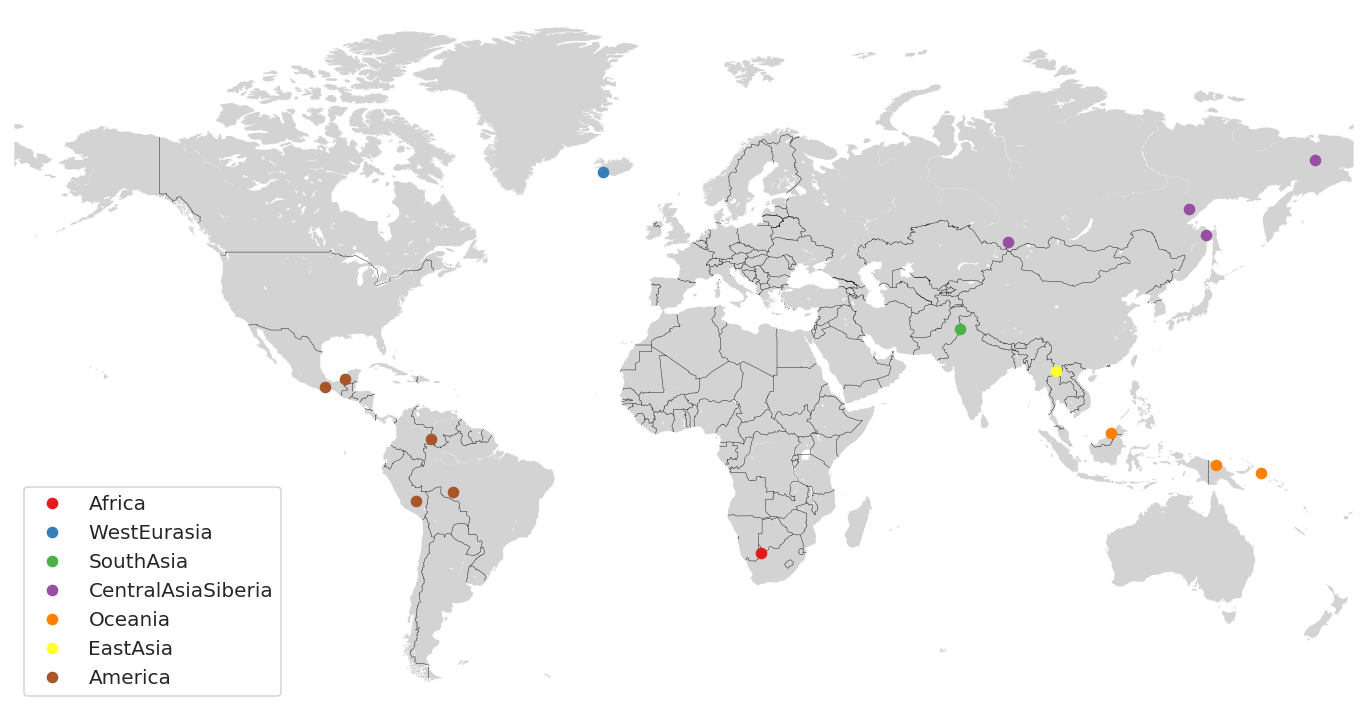

In [28]:
plt.close()


#with sns.color_palette(['#5a5252', '#F564E3', '#B79F00', '#619CFF', '#00BFC4', '#00BA38', '#F8766D']):
with sns.color_palette("Set1", 7):

    fig = plt.figure(figsize=(12,8))
    # back to remove border around map
    ax = fig.add_subplot(111)
    ax.axis('off')

    m = Basemap(projection='mill',
                urcrnrlon=180, 
                urcrnrlat=85,
                llcrnrlon=-180,
                llcrnrlat=-60,
                resolution='l', # 'c' is crude, l is low, i is intermediate, h is high, f is full
                suppress_ticks=True)
    m.fillcontinents(color='lightgrey',lake_color='white', zorder=0)
    m.drawcountries(linewidth=0.2, linestyle='solid', color='black', zorder=1)

    df = pi_data_chrX[['population', 'region', 'longitude_center', 'latitude_center']].drop_duplicates()

    xvals, yvals = zip(*[m(*p) for p in zip(df.longitude_center, df.latitude_center)])
#     for x, y, lab in zip(xvals, yvals, df.population):
#         plt.text(x, y, str(lab))
    
    groups = df.groupby('region')
    for name, group in groups:
        xvals, yvals = zip(*[m(*p) for p in zip(group.longitude_center, group.latitude_center)])
        m.plot(xvals, yvals, marker='o', linestyle='', label=name)

    plt.legend(loc=3, fontsize=10)

    plt.savefig(str(figures_dir / "simons_worldmap.pdf"))
    
    plt.show()
    
#mpld3.display(fig)


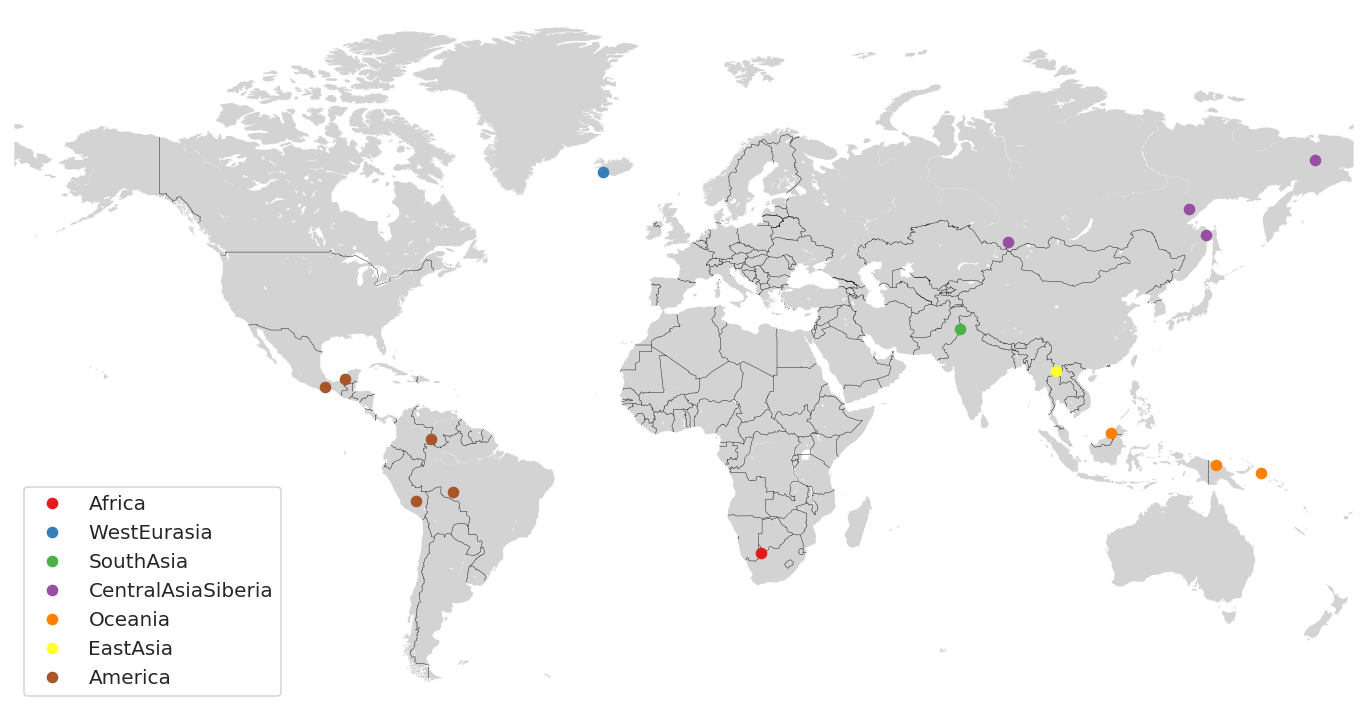

In [29]:
plt.close()


#with sns.color_palette(['#5a5252', '#F564E3', '#B79F00', '#619CFF', '#00BFC4', '#00BA38', '#F8766D']):
with sns.color_palette("Set1", 7):

    fig = plt.figure(figsize=(12,8))
    # back to remove border around map
    ax = fig.add_subplot(111)
    ax.axis('off')

    m = Basemap(projection='mill',
                urcrnrlon=180, 
                urcrnrlat=85,
                llcrnrlon=-180,
                llcrnrlat=-60,
                resolution='l', # 'c' is crude, l is low, i is intermediate, h is high, f is full
                suppress_ticks=True)
    m.fillcontinents(color='lightgrey',lake_color='white', zorder=0)
    m.drawcountries(linewidth=0.2, linestyle='solid', color='black', zorder=1)

    df = pi_data_chrX[['population', 'region', 'longitude_center', 'latitude_center']].drop_duplicates()

    
#     import analysis_globals
# #    print(analysis_globals.excluded_pops)
#     df = df.loc[df.population.isin(analysis_globals.populations)]
    
    
    xvals, yvals = zip(*[m(*p) for p in zip(df.longitude_center, df.latitude_center)])
#     for x, y, lab in zip(xvals, yvals, df.population):
#         plt.text(x, y, str(lab))
    
    groups = df.groupby('region')
    for name, group in groups:
        xvals, yvals = zip(*[m(*p) for p in zip(group.longitude_center, group.latitude_center)])
        m.plot(xvals, yvals, marker='o', linestyle='', label=name)

    plt.legend(loc=3, fontsize=10)

    plt.savefig(str(figures_dir / "simons_used_males_worldmap.pdf"))
    
    plt.show()
    
#mpld3.display(fig)


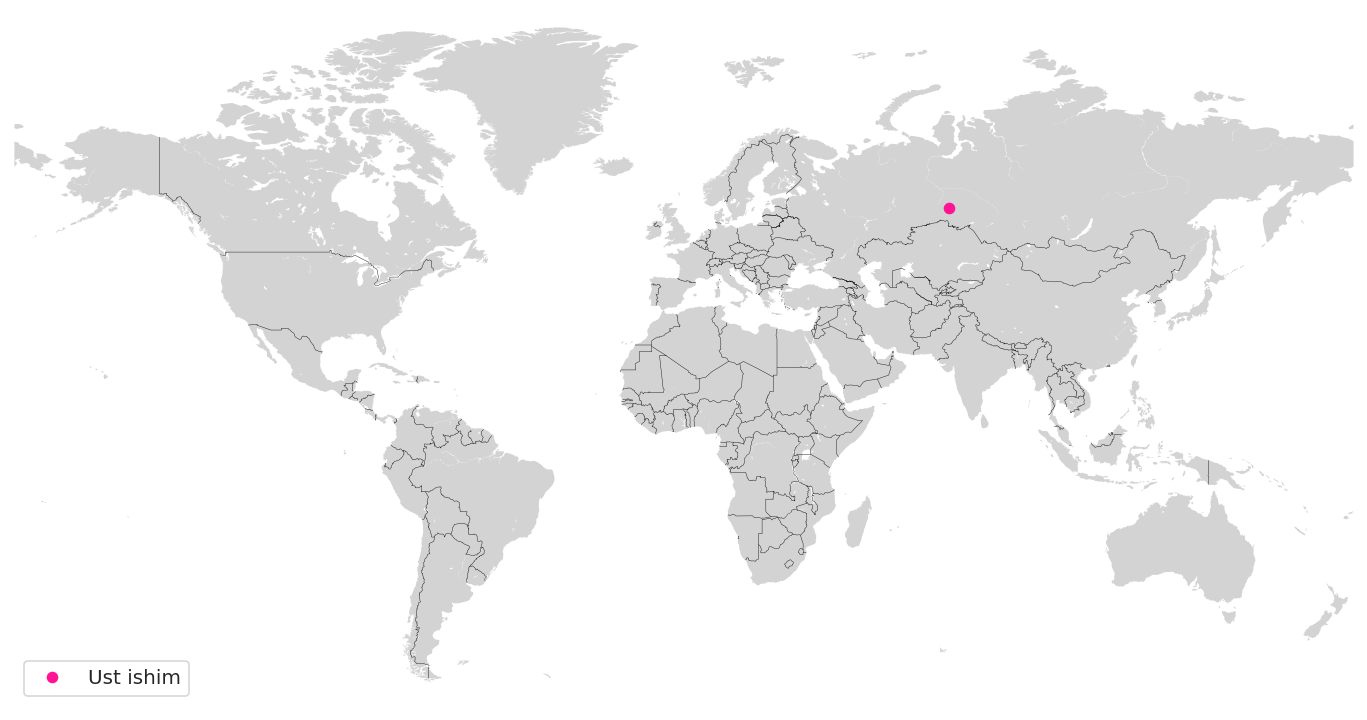

In [30]:
plt.close()


#with sns.color_palette(['#5a5252', '#F564E3', '#B79F00', '#619CFF', '#00BFC4', '#00BA38', '#F8766D']):
with sns.color_palette("Set1", 7):

    fig = plt.figure(figsize=(12,8))
    # back to remove border around map
    ax = fig.add_subplot(111)
    ax.axis('off')

    m = Basemap(projection='mill',
                urcrnrlon=180, 
                urcrnrlat=85,
                llcrnrlon=-180,
                llcrnrlat=-60,
                resolution='l', # 'c' is crude, l is low, i is intermediate, h is high, f is full
                suppress_ticks=True)
    m.fillcontinents(color='lightgrey',lake_color='white', zorder=0)
    m.drawcountries(linewidth=0.2, linestyle='solid', color='black', zorder=1)

    df = pi_data_chrX[['population', 'region', 'longitude_center', 'latitude_center']].drop_duplicates()

    # Longitude of Ust ishim: 71.167194
    # Latitude of Ust ishim: 57.692596
    
    #xvals, yvals = zip(*[m(*p) for p in zip(df.longitude_center, df.latitude_center)])
    xval, yval = m(71.167194, 57.692596)
    
    m.plot(xval, yval, marker='o', linestyle='', color='deeppink', label='Ust ishim')

    plt.legend(loc=3, fontsize=10)

    plt.savefig(str(figures_dir / "simons_worldmap_ust_ishim.pdf"))
    
    plt.show()
    
#mpld3.display(fig)


# General properties of pi across populations and regions

### Global mean pi

In [31]:
cols = ['chrom', 'region', 'population', 'pi']
df = (pandas.concat([pi_data_chrX.loc[~pi_filter_mask_chrX, cols], 
                    pi_data_chr7.loc[~pi_filter_mask_chr7, cols]])
      .groupby(['chrom', 'region', 'population'])
      .aggregate(numpy.nanmean)
      .reset_index()
     )

In [32]:
df.population.cat.categories

Index(['BantuHerero', 'BantuKenya', 'BantuTswana', 'Biaka', 'Dinka', 'Esan',
       'Gambian', 'Ju_hoan_North', 'Khomani_San', 'Luhya',
       ...
       'Yi', 'Karitiana', 'Mayan', 'Mixe', 'Mixtec', 'Piapoco', 'Pima',
       'Quechua', 'Surui', 'Zapotec'],
      dtype='object', length=110)

Mean $\pi$ of French population:

In [33]:
df.loc[df.population == 'French'].pi.mean()

0.0007703769616492462

Mean $\pi$ of non-African and African populations respectively:

In [34]:
df.loc[df.region != 'Africa'].pi.mean(), df.loc[df.region == 'Africa'].pi.mean()

(0.0006833312423183862, 0.0009963187322842265)

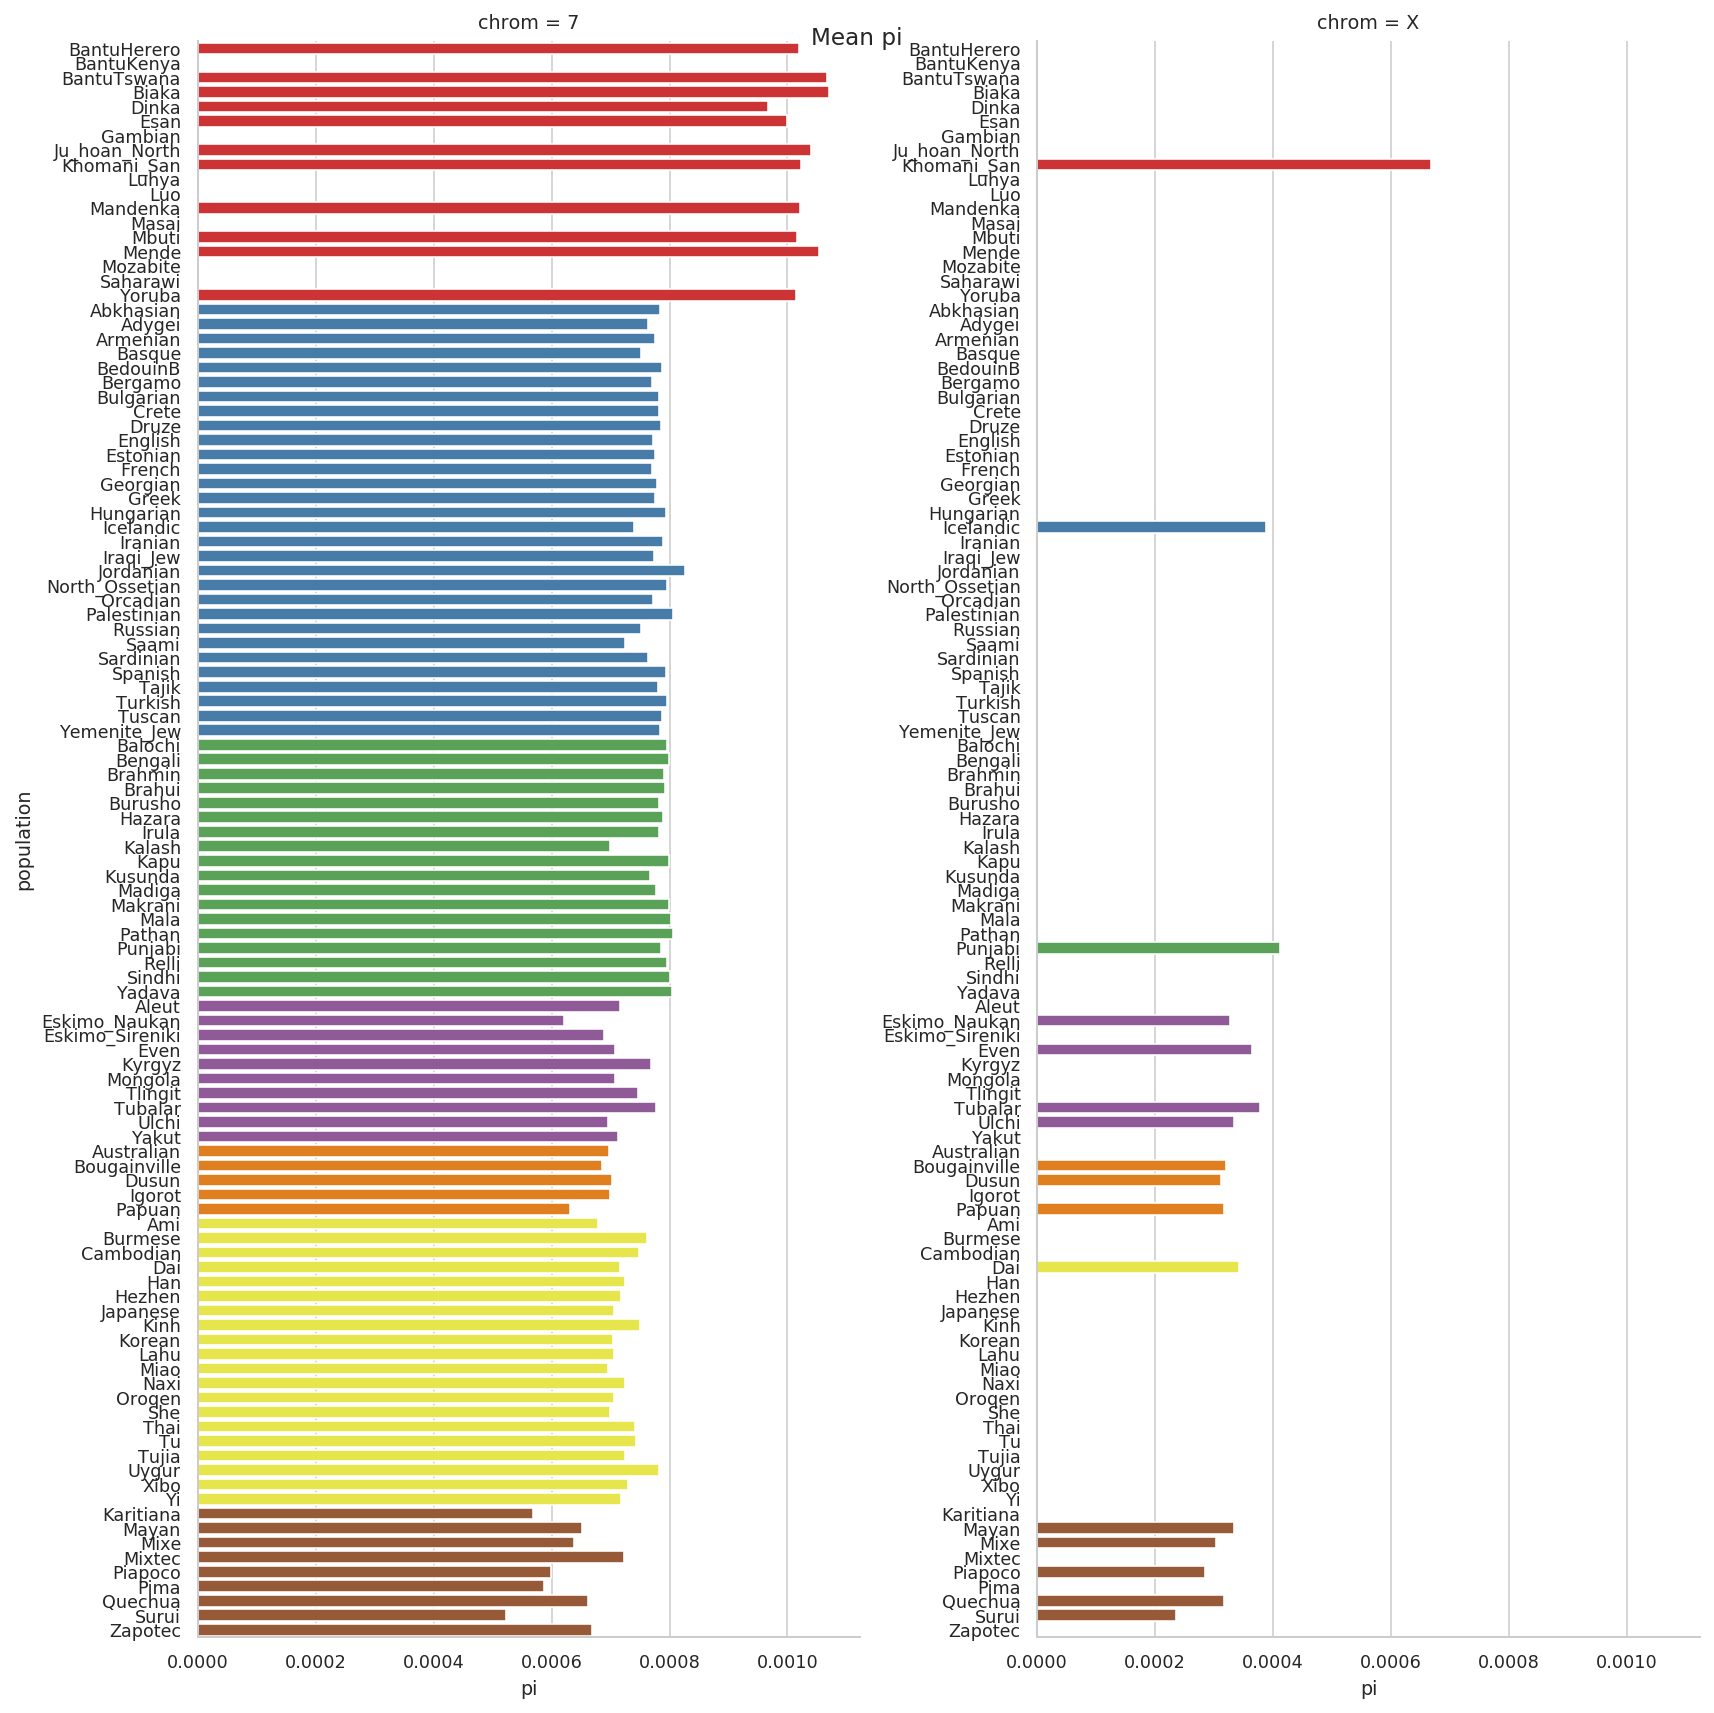

In [35]:
with sns.plotting_context('paper'):
    with sns.color_palette("Set1", 7):
        g = sns.FacetGrid(df, col="chrom", hue='region', height=12, aspect=0.5, sharey=False)
        g = g.map(sns.barplot, 'pi', 'population', edgecolor=None, ci=None, order=df.population.cat.categories)
        g.fig.suptitle('Mean pi')

        plt.savefig(str(figures_dir / "mean_pop_pi.pdf"))

### Number of windows in each population where pi is zero:

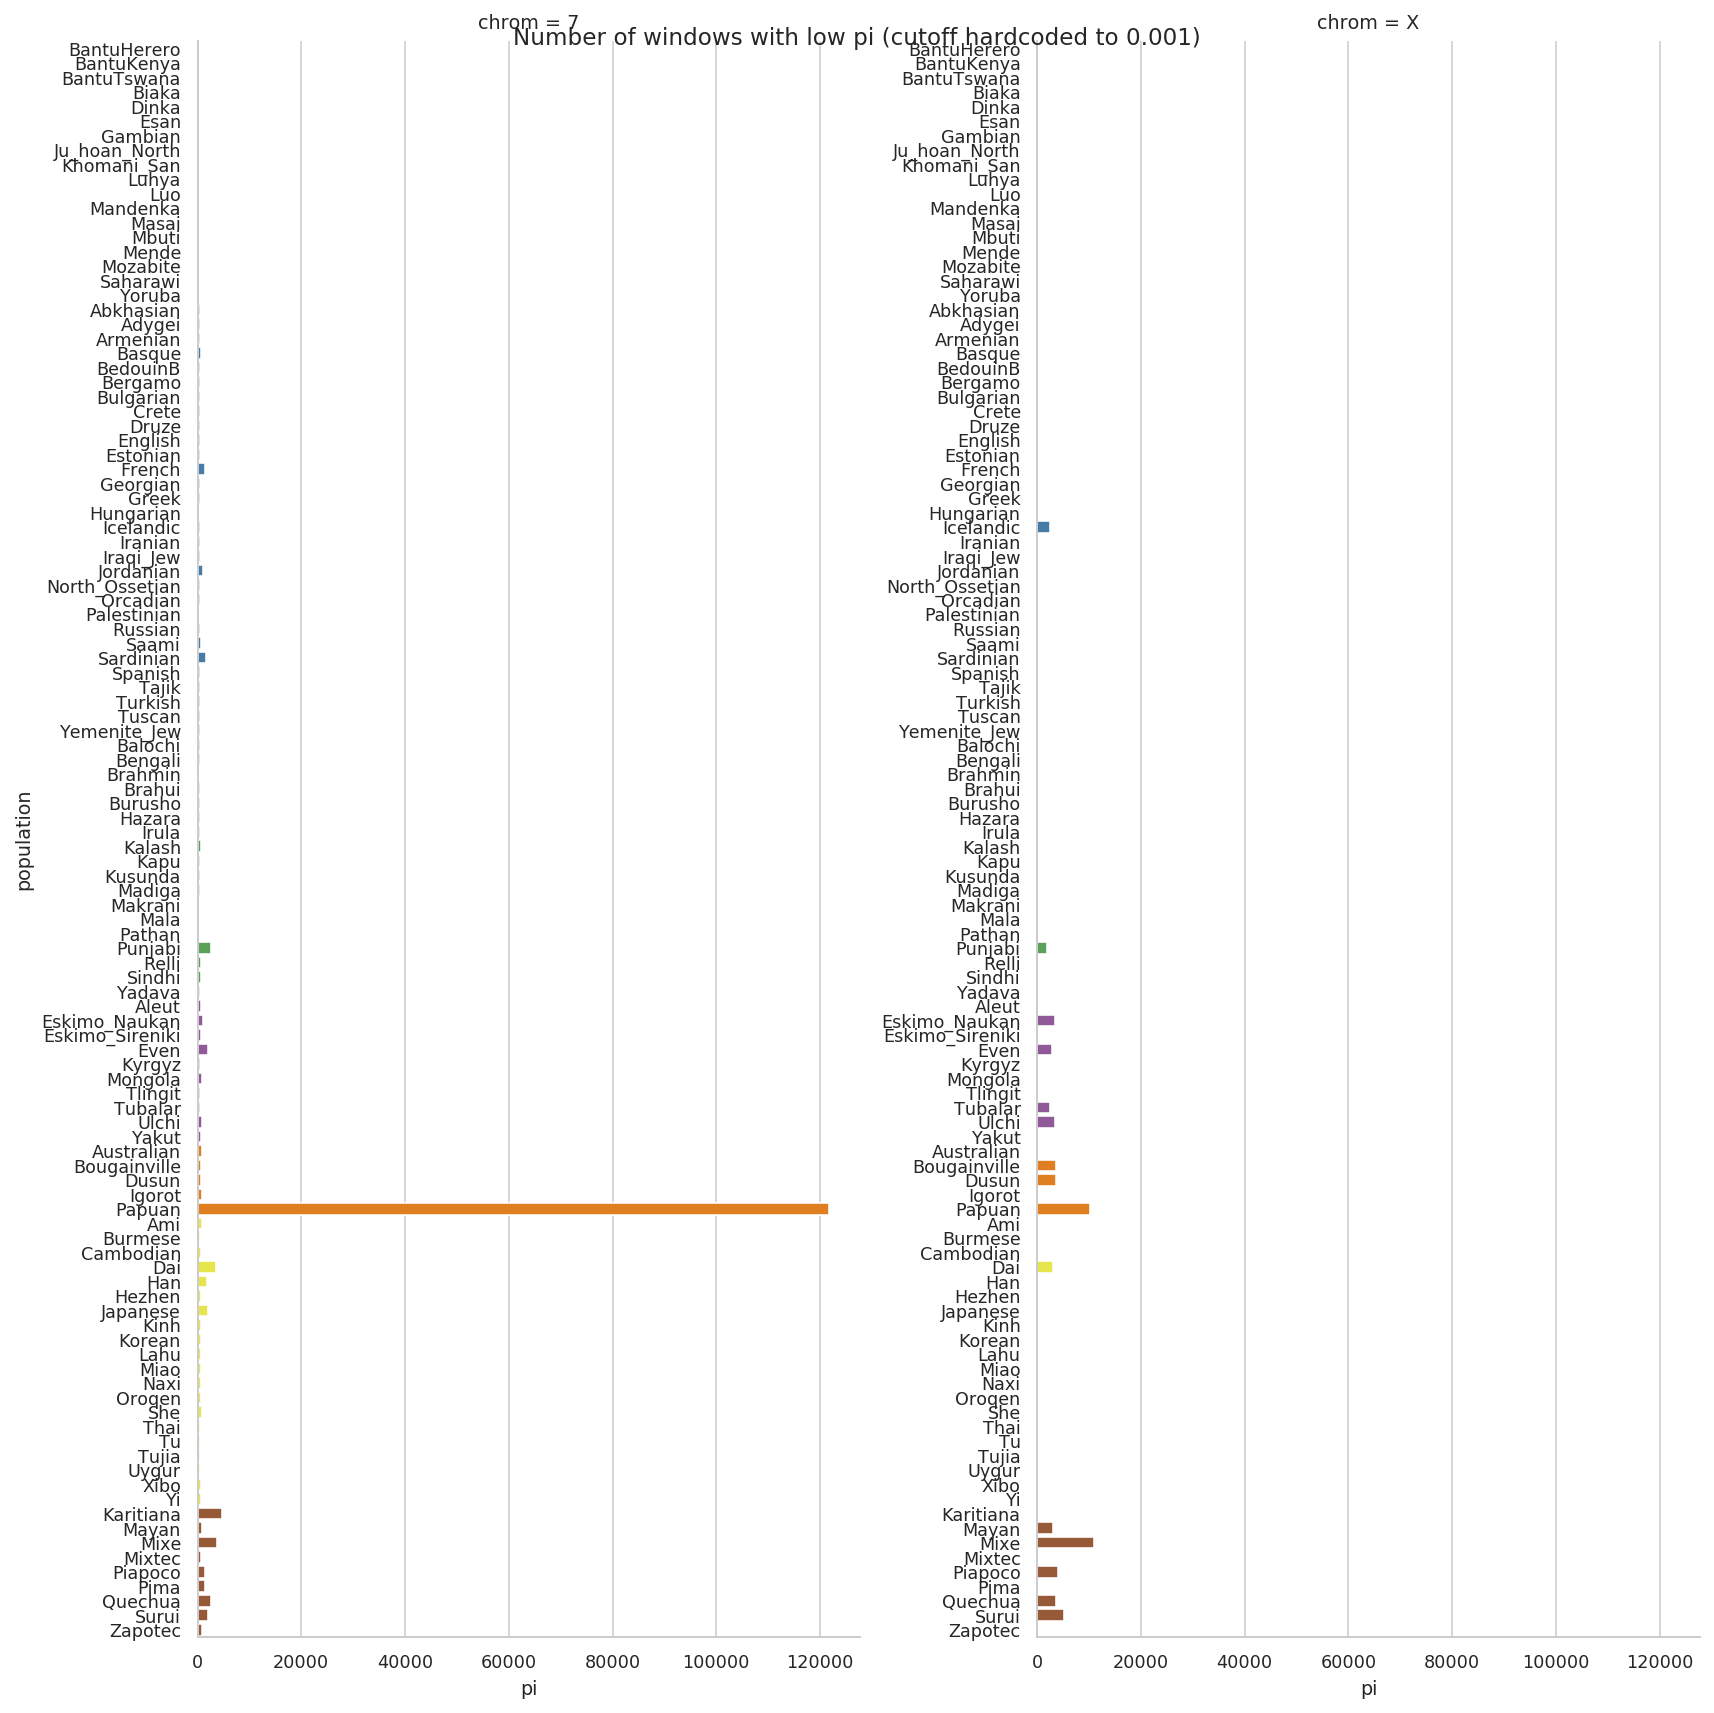

In [36]:
cols = ['chrom', 'region', 'population', 'pi']
df = (pandas.concat([pi_data_chrX.loc[~pi_filter_mask_chrX, cols], 
                     pi_data_chr7.loc[~pi_filter_mask_chr7, cols]])
      .groupby(['chrom', 'region', 'population'])
      .aggregate(lambda x: sum(x <= 0.0001))
      .reset_index()
     )

with sns.plotting_context('paper'):
    with sns.color_palette("Set1", 7):
        g = sns.FacetGrid(df, col="chrom", hue='region', height=12, aspect=0.5, sharey=False)
        g = g.map(sns.barplot, 'pi', 'population', edgecolor=None, ci=None, order=df.population.cat.categories)
        g.fig.suptitle('Number of windows with low pi (cutoff hardcoded to 0.001)')
        
        plt.savefig(str(figures_dir / "counts_lowpi_windows.pdf"))

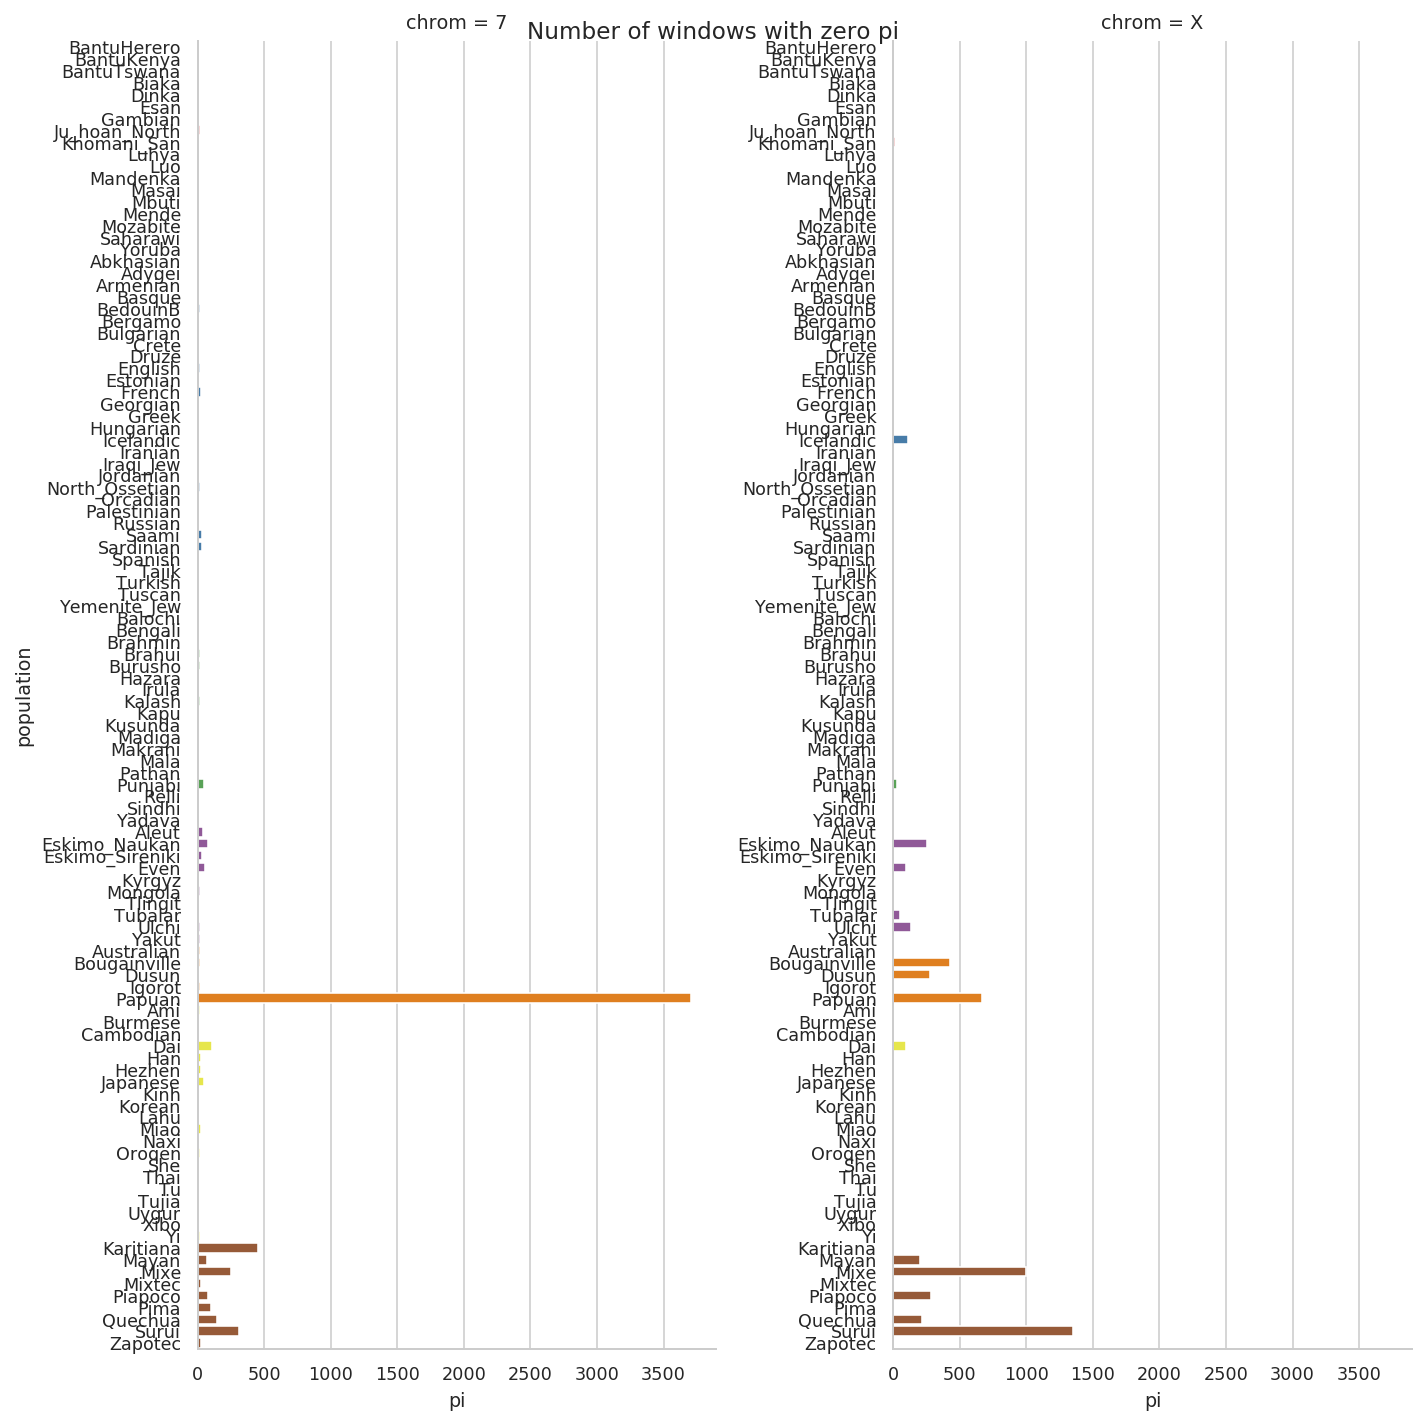

In [37]:
cols = ['chrom', 'region', 'population', 'pi']
df = (pandas.concat([pi_data_chrX.loc[~pi_filter_mask_chrX, cols], 
                     pi_data_chr7.loc[~pi_filter_mask_chr7, cols]])
      .groupby(['chrom', 'region', 'population'])
      .aggregate(lambda x: sum(x == 0))
      .reset_index()
     )

with sns.plotting_context('paper'):
    with sns.color_palette("Set1", 7):
        g = sns.FacetGrid(df, col="chrom", hue='region', height=10, aspect=0.5, sharey=False)
        g = g.map(sns.barplot, 'pi', 'population', edgecolor=None, ci=None, order=df.population.cat.categories)
        g.fig.suptitle('Number of windows with zero pi')
        plt.savefig(str(figures_dir / "counts_zeropi_windows.pdf"))

### Log distributions of pi in windows (excluding windows with zero pi):

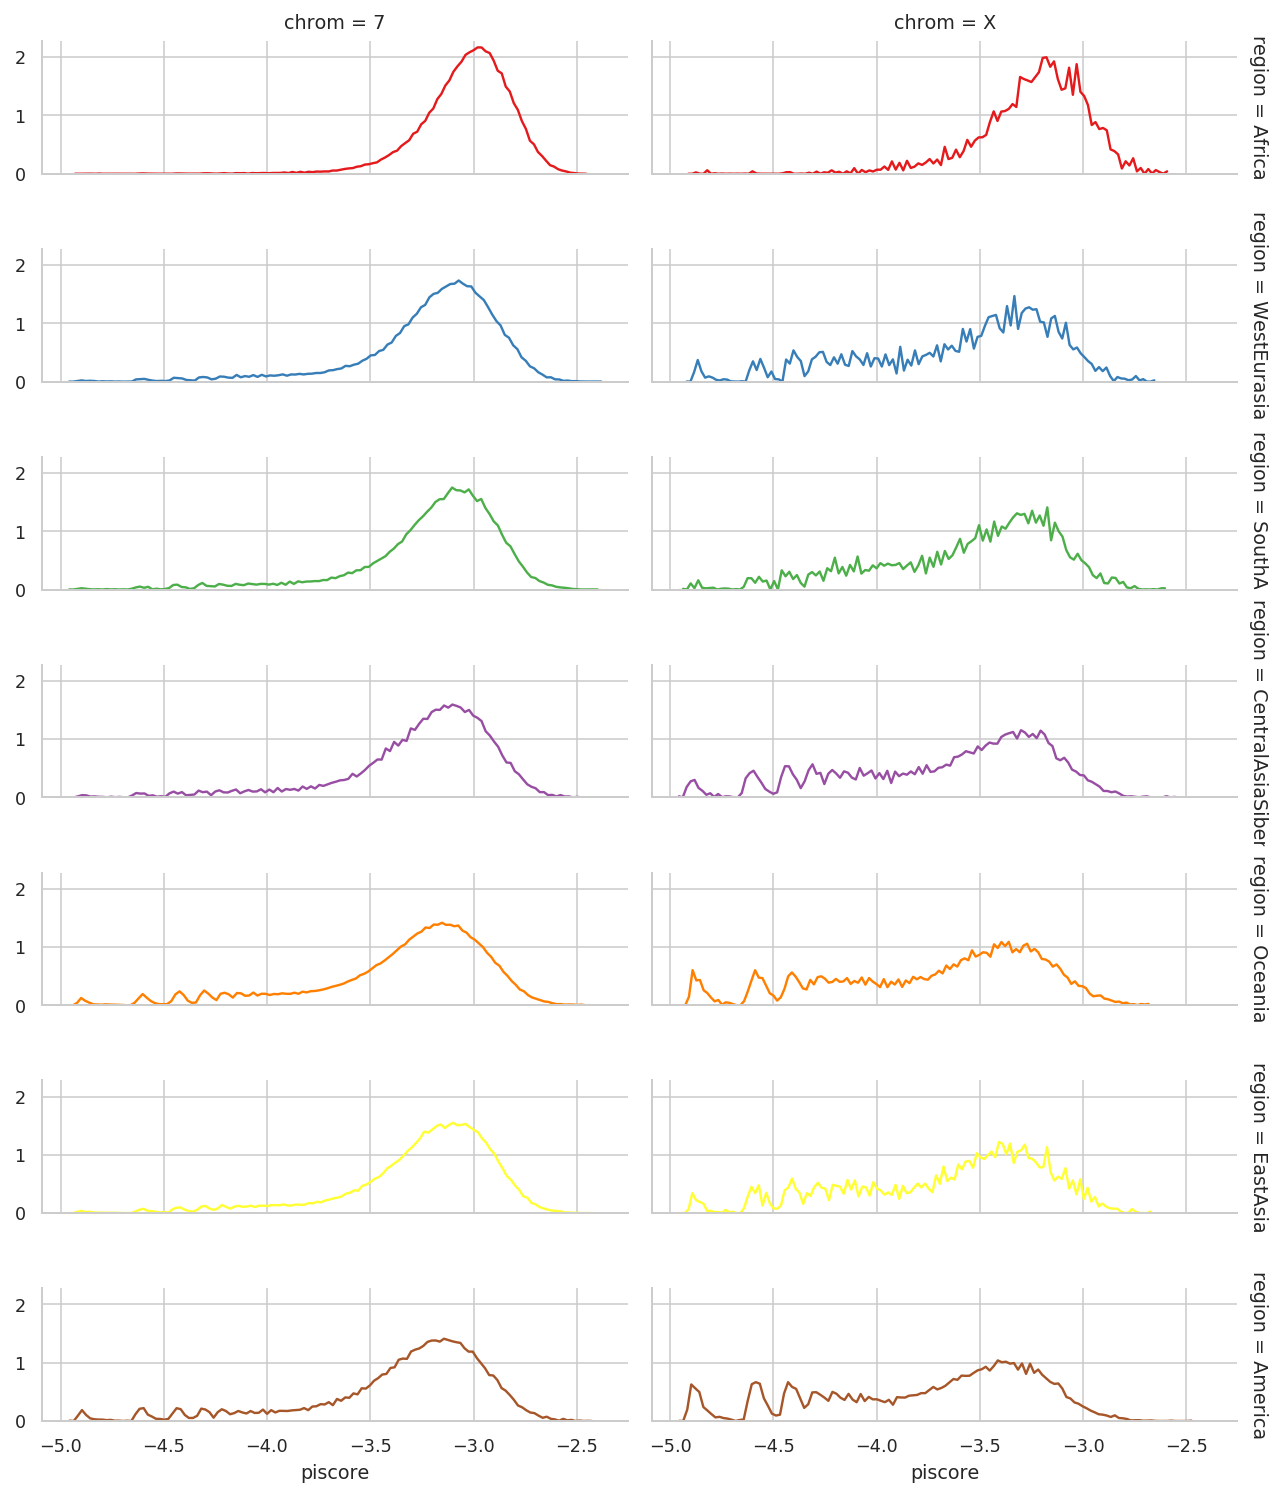

In [38]:
#     with sns.axes_style('dark'): # whitegrid, ticks

#with sns.plotting_context('notebook', font_scale=1.2): # paper, notebook, talk”, poster
with sns.plotting_context('paper'): # paper, notebook, talk”, poster

    df = (pandas.concat([pi_data_chr7, pi_data_chrX])
          .loc[~numpy.concatenate((pi_filter_mask_chr7, pi_filter_mask_chrX)), ['chrom', 'region', 'population', 'pi']]
          .loc[lambda df: df.pi > 0]
          .assign(piscore=lambda df: numpy.log10(df.pi))
         )
#     g = sns.FacetGrid(df, row="region", col='chrom', hue="region", 
#                       size=1.5, aspect=3, palette='Set1', margin_titles=False)
#     g = (g.map(sns.kdeplot, 'piscore', bw=0.00001).set_titles(["chrom {col_name}", "{row_name}"]))
    g = sns.FacetGrid(df, row="region", col='chrom', hue="region", 
                      height=1.5, aspect=3, palette='Set1', margin_titles=True)
    g = g.map(sns.kdeplot, 'piscore', bw=0.00001)

    plt.savefig(str(figures_dir / "log_distr_pi_regions.pdf"))

### Coeficient of variation versus mean pi 

In [39]:
def cv_and_mean(df):
    odd_pi = df.pi[0:df.pi.size:2]
    even_pi = df.pi[1:df.pi.size:2]
    return DataFrame({'mean_pi_odd': [numpy.mean(odd_pi)], 
                      'cv_pi_even': [numpy.var(even_pi) / numpy.mean(even_pi)]})

cols = ['chrom', 'region', 'start', 'pi']
df = (pandas.concat([pi_data_chrX.loc[~pi_filter_mask_chrX, cols], 
                     pi_data_chr7.loc[~pi_filter_mask_chr7, cols]])
      .reset_index()
      .groupby(['chrom', 'region', 'start'])
      .apply(cv_and_mean)
      .reset_index()
     )

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


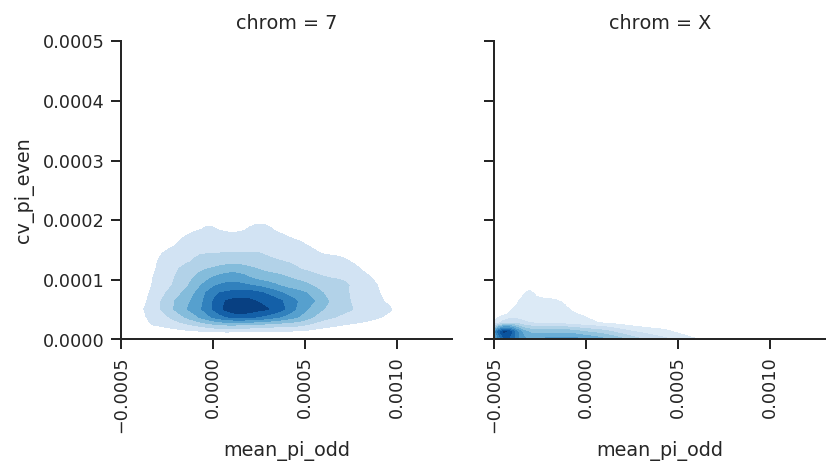

In [40]:
with sns.plotting_context('paper'):
    with sns.axes_style("ticks"):
        g = sns.FacetGrid(df, col="chrom", margin_titles=True)
        g = (g.map(sns.kdeplot, 'mean_pi_odd', 'cv_pi_even', cmap="Blues", 
                   shade=True, shade_lowest=False)
             .set(xlim=(0, 0.0018), ylim=(0, 0.0005))
            )
        g.set_xticklabels(rotation=90)
        plt.savefig(str(figures_dir / "cv_vs_mean_pi.pdf"))

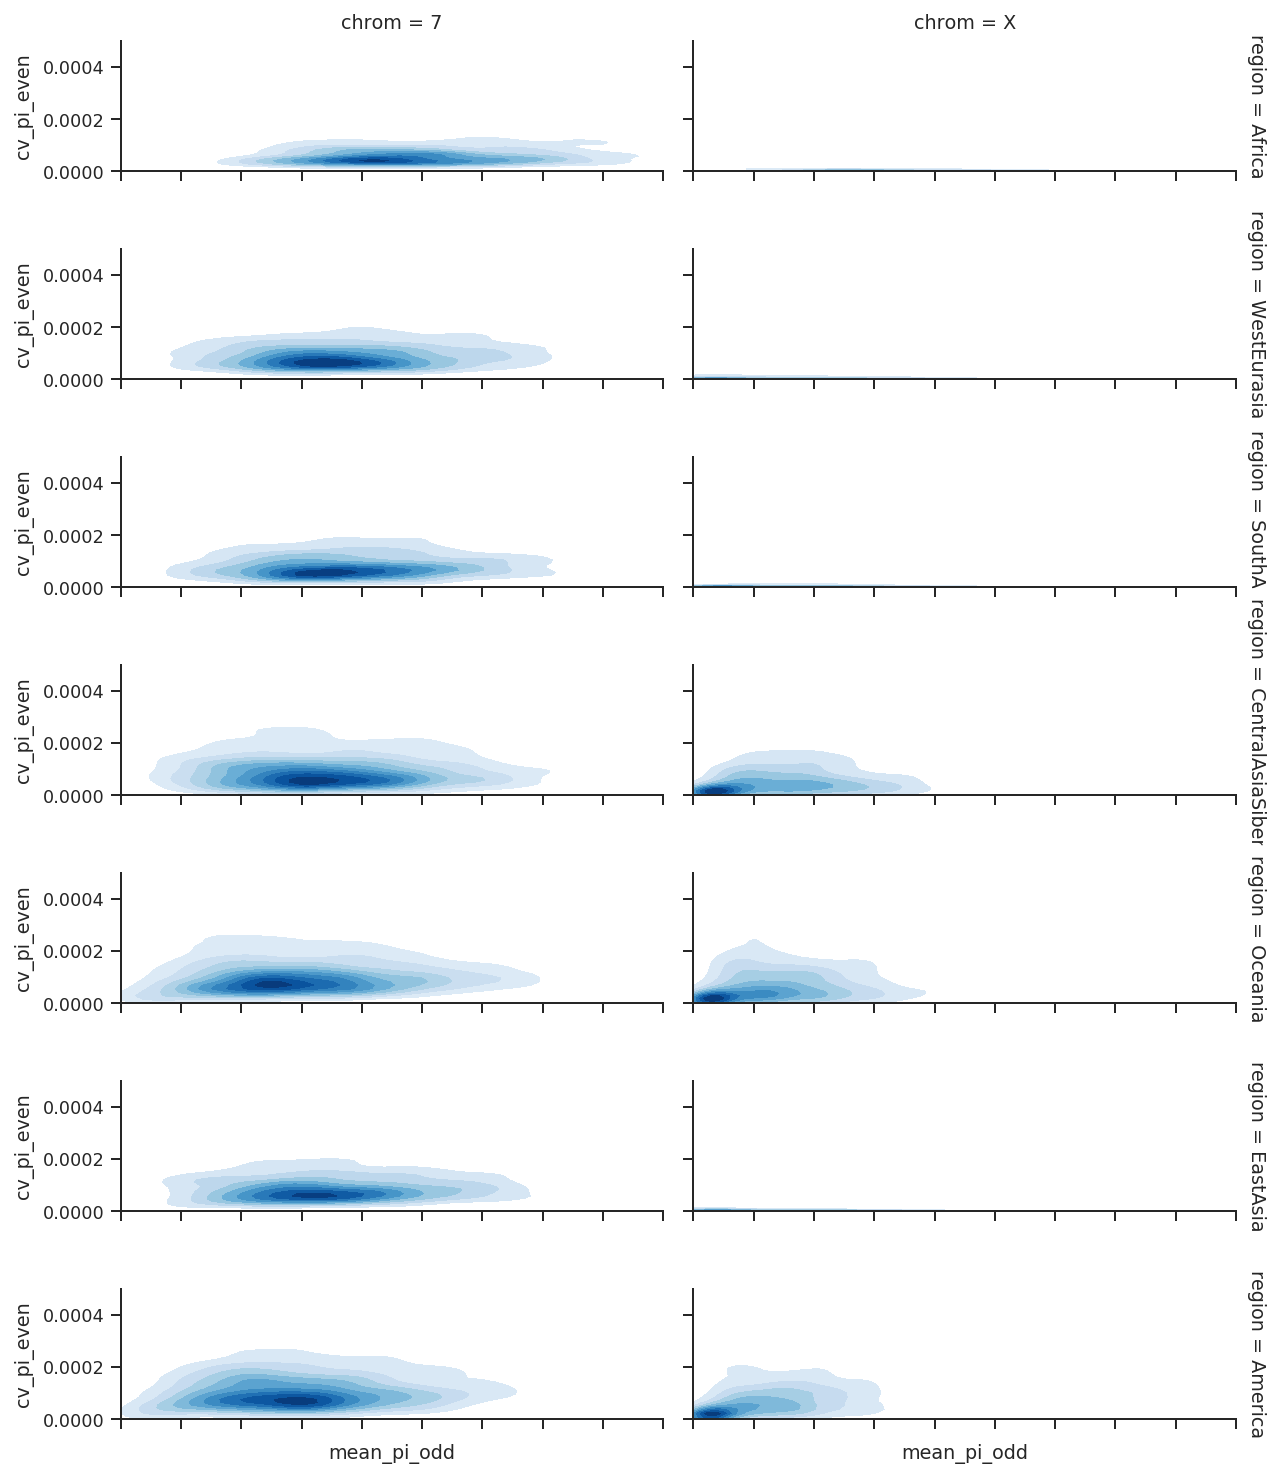

In [41]:
with sns.plotting_context('paper'):
    with sns.axes_style("ticks"):
        g = sns.FacetGrid(df, col="chrom", row='region', height=1.5, aspect=3, margin_titles=True)
        g = (g.map(sns.kdeplot, 'mean_pi_odd', 'cv_pi_even', cmap="Blues", 
                   shade=True, shade_lowest=False)
             .set(xlim=(0, 0.0018), ylim=(0, 0.0005))
            )
        g.set_xticklabels(rotation=90)
        plt.savefig(str(figures_dir / "cv_vs_mean_pi.pdf"))

It is clear that the density "dips into the corner", showing that not only does the X have an enrichment of low pi regions, but these low regions also show less variation than  similarly low regions on chr7. Expected from sweeps not BGS.

### Differences between pairs of individuals from a population accross chrX

    Papuan            15
    Dai                4
    Mbuti              4
    Ju_hoan_North      4
    Punjabi            4
    Jordanian          3
    Han                3
    Quechua            3
    Yoruba             3
    Mixe               3
    Finnish            3
    Dinka              3
    Sardinian          3
    Japanese           3
    French             3
    Karitiana          3
    Mandenka           3
    Even               3

In [42]:
plot_populations = set(['Yoruba', 
                    'French', 
                    'Irula',
                    'Even',
                    'Han',
                    'Bourgainville',
                    'Quechua'])

plot_individuals = set(indiv for pop in plot_populations for indiv in populations[pop])

from scipy.interpolate import UnivariateSpline


def nan_spline(x, y, **kwargs):
    w = numpy.isnan(y)
    y = y[:]
    y[w] = 0.
    return UnivariateSpline(x, y, w=~w, **kwargs)

plot_df = (pi_data_chrX#[['start', 'pop_label', 'indiv_1', 'indiv_2', 'pseud_1', 'pseud_2', 'pi']]           
           .loc[lambda df: df.indiv_1.isin(plot_individuals) & df.indiv_2.isin(plot_individuals) & \
                (df.pseud_1 == 'A') & (df.pseud_2 == 'A')]
           .assign(indiv_pair = lambda df: ["{}_{}".format(x.strip(), y.strip()) for x, y in zip(df.indiv_1, df.indiv_2)])
           .loc[lambda df: ~numpy.isnan(df.pi)]
           .groupby(['pop_label', 'indiv_pair'])
#           .apply(lambda df: df.assign(smooth = interp1d(df.start, df.pi, kind='cubic')(df.start)))
            .apply(lambda df: df.assign(smooth = nan_spline(df.start, df.pi, s=0.00001)(df.start)))
           .reset_index()
          )

In [43]:
diff = 6e-05
mut_rate = 5e-10
diff / (mut_rate * 2)

60000.0

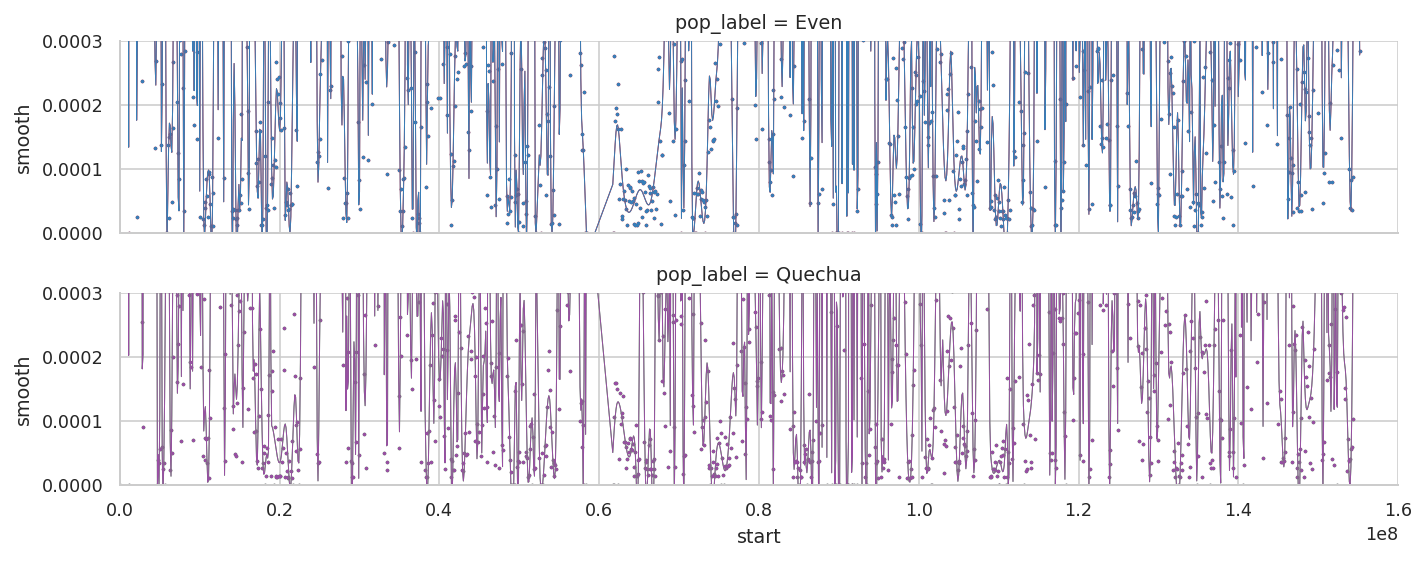

In [44]:
g = sns.FacetGrid(plot_df, row='pop_label', hue='indiv_pair', 
                  height=2, aspect=5, sharey=True, palette=sns.color_palette("Set1"))

g = (g.map(plt.scatter, 'start', "pi", s=1)       
        .set(
            ylim=(0, 0.0003),
             xlim=(0, 1.6e8))
      )
g = (g.map(plt.plot, 'start', "smooth", linewidth=.5)       

      )
#mpld3.display(g.fig)
# plt.savefig(str(figures_dir / "pairwise_diffs_{}_{}.pdf".format(indiv_1, indiv_2)))

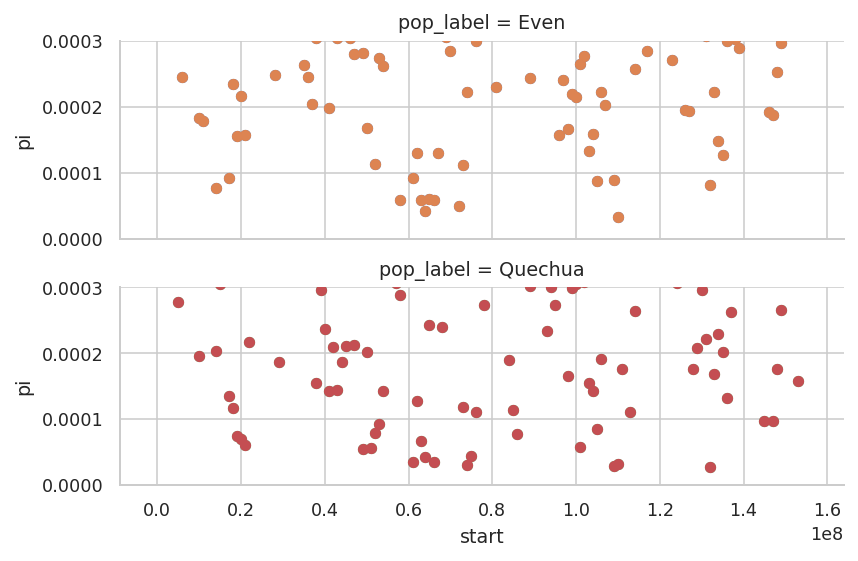

In [45]:
plot_mb_df = (plot_df
              .assign(binlab = lambda df: [x // 1000000 for x in df.start])
              .groupby(['pop_label', 'indiv_pair', 'binlab'])
              .aggregate(numpy.mean)
              .reset_index()
              .assign(start = lambda df: df.binlab * 1000000)
            )

g = sns.FacetGrid(plot_mb_df, row='pop_label', hue='indiv_pair', height=2, aspect=3, sharey=True)

g = (g.map(plt.scatter, 'start', "pi")       
        .set(ylim=(0, 0.0003))
      )

### Pi across the world

Chromosome X:

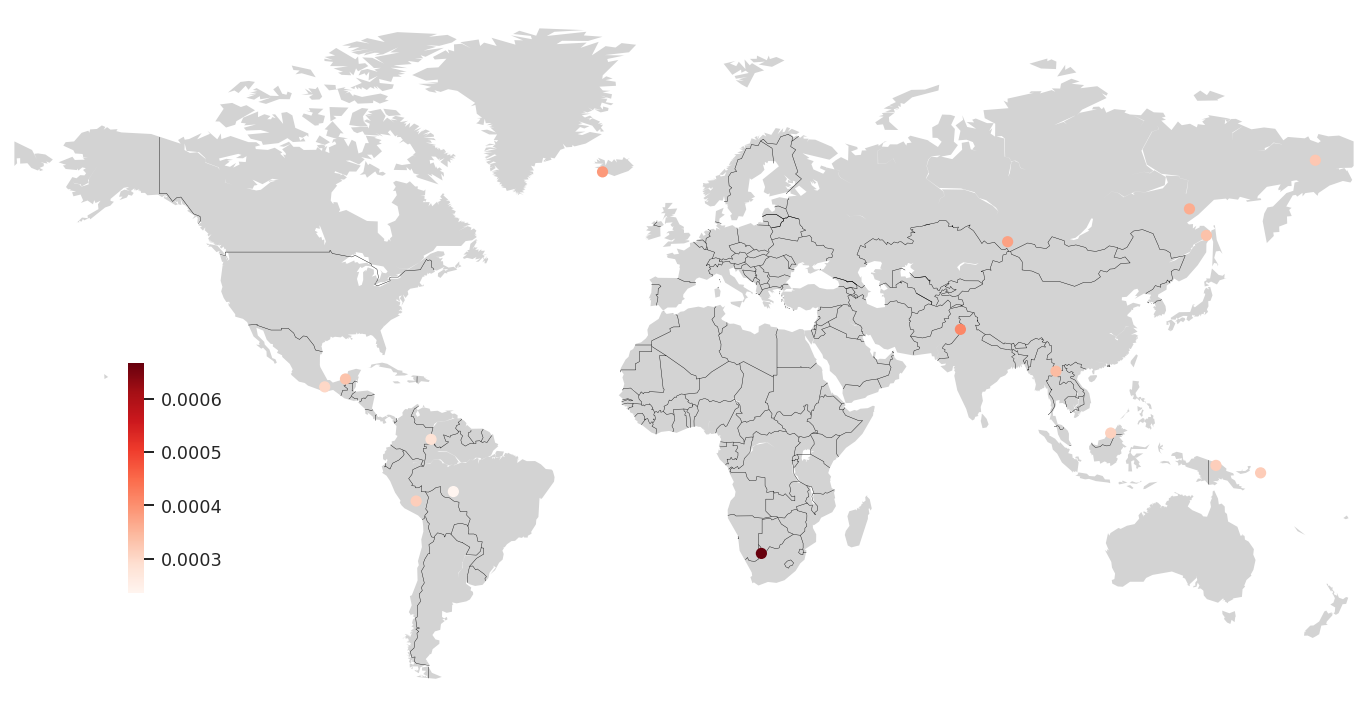

In [46]:
fig = plt.figure(figsize=(12,8))
# back to remove border around map
ax = fig.add_subplot(111)
ax.axis('off')

m = Basemap(projection='mill',
            urcrnrlon=180, 
            urcrnrlat=85,
            llcrnrlon=-180,
            llcrnrlat=-60,
            resolution='c', # 'c' is crude, l is low, i is intermediate, h is high, f is full
            suppress_ticks=True)
m.fillcontinents(color='lightgrey',lake_color='white', zorder=0)
m.drawcountries(linewidth=0.2, linestyle='solid', color='black', zorder=1)

df = (pi_data_chrX
  .loc[~pi_filter_mask_chrX, ['population', 'longitude_center', 'latitude_center', 'pi']]
  .groupby(['population'])
  .aggregate(numpy.nanmean)
  .reset_index()
 )

xvals, yvals = zip(*[m(*p) for p in zip(df.longitude_center, df.latitude_center)])
scatter = m.scatter(xvals, yvals, marker='o', c=df.pi, cmap=matplotlib.cm.Reds)

# Add colorbar         x   y    width height
cbaxes = fig.add_axes([0, 0.3, 0.2, 0.2], visible=False) 
cb = m.colorbar(scatter, ax=cbaxes)
cb.outline.set_color('none')

plt.savefig(str(figures_dir / "pi_world_map.pdf"))

#mpld3.display(fig)
plt.show()

Chromosome 7:


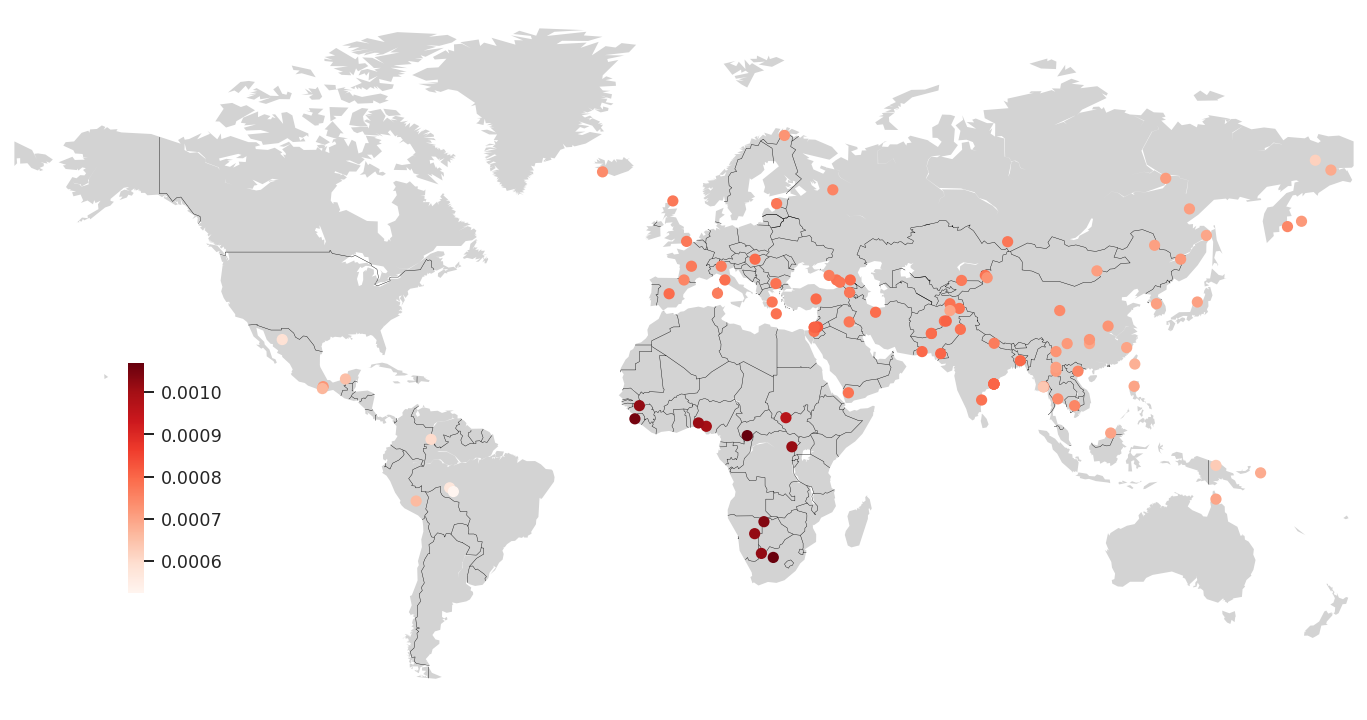

In [47]:
fig = plt.figure(figsize=(12,8))
# back to remove border around map
ax = fig.add_subplot(111)
ax.axis('off')

m = Basemap(projection='mill',
            urcrnrlon=180, 
            urcrnrlat=85,
            llcrnrlon=-180,
            llcrnrlat=-60,
            resolution='c', # 'c' is crude, l is low, i is intermediate, h is high, f is full
            suppress_ticks=True)
m.fillcontinents(color='lightgrey',lake_color='white', zorder=0)
m.drawcountries(linewidth=0.2, linestyle='solid', color='black', zorder=1)

df = (pi_data_chr7
  .loc[~pi_filter_mask_chr7, ['population', 'longitude_center', 'latitude_center', 'pi']]
  .groupby(['population'])
  .aggregate(numpy.nanmean)
  .reset_index()
 )

xvals, yvals = zip(*[m(*p) for p in zip(df.longitude_center, df.latitude_center)])
scatter = m.scatter(xvals, yvals, marker='o', c=df.pi, cmap=matplotlib.cm.Reds)

# Add colorbar         x   y    width height
cbaxes = fig.add_axes([0, 0.3, 0.2, 0.2], visible=False) 
cb = m.colorbar(scatter, ax=cbaxes)
cb.outline.set_color('none')

#mpld3.display(fig)
plt.show()

### PCA of pi

It looks like the X chromosome pi declines more steeply our of Africa, but that could easily be Pool-Nielsen effect.

In [48]:
def make_pca_input(data, mask):
    pi_df = (data
             .loc[:, ['region', 'population', 'start', 'pi']]
             .assign(pi = lambda df: df.pi.where(~mask))
             .groupby(['start', 'region', 'population'])
             .aggregate(silent_nanmean)
             .reset_index()
             .loc[lambda df: ~numpy.isnan(df.pi)]
            )
    # needs to be sorted by region so we can extract matching region codes
    pi_df.sort_values(by=['region', 'population'], inplace=True)  
    region_sr = (pi_df[['region', 'population']]
                    .drop_duplicates()
                    .loc[:, 'region']
                   ) 
    pi_matrix = (pi_df
                 .pivot(index='population', columns='start', values='pi')
                 .dropna(axis=1) # Drop cols with NaN
                 .as_matrix()
                )
    return pi_matrix, region_sr

def pca_df(matrix, labels):
    pca = PCA(n_components=2)
    pca.fit(pi_matrix)
    trans = pca.transform(pi_matrix)
    df = DataFrame({'PC1':trans[:, 0], 'PC2':trans[:, 1], 'Region':labels})  
    return(df)

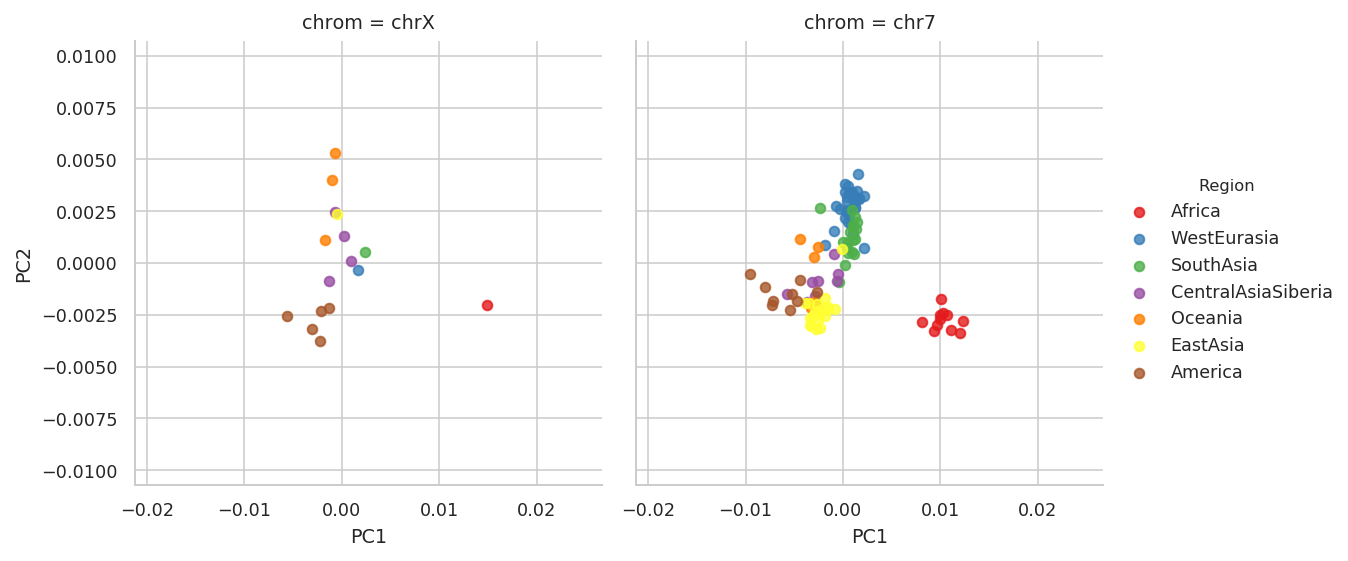

In [49]:
# chrX
pi_matrix, row_cats = make_pca_input(pi_data_chrX, pi_filter_mask_chrX)
pca_df_chrX = pca_df(pi_matrix, row_cats)
pca_df_chrX['chrom'] = 'chrX'
# chr7
pi_matrix, row_cats = make_pca_input(pi_data_chr7, pi_filter_mask_chr7)
pca_df_chr7 = pca_df(pi_matrix, row_cats)
pca_df_chr7['chrom'] = 'chr7'

df = pandas.concat([pca_df_chrX, pca_df_chr7])

with sns.color_palette("Set1", 7):
    sns.lmplot(data=df, x='PC1', y='PC2', hue='Region', col='chrom', fit_reg=False, height=4)
    plt.savefig(str(figures_dir / "pi_pca.pdf"))


# Heat maps for pi landscape across populations

First with no filtering:

In [50]:
cols = ['chrom', 'population', 'start', 'uncalled']
plot_df = (pi_data_chrX
           .loc[:, cols]
           .groupby(['chrom', 'start', 'population'])
           .aggregate(silent_nanmean)
           .reset_index()
           .pivot(index='population', columns='start', values='uncalled')
          )

fig, ax = plt.subplots(figsize=(12, 15))
ax = sns.heatmap(plot_df, xticklabels=200, ax=ax, #cmap="Blues", 
                 cbar_kws={'aspect': 50})
ax.set_title('Unfiltered pi values')
plt.savefig(str(figures_dir / "pi_heatmap_chrX_unfiltered.pdf"))
plt.close() # closing teh plot suppres automatic plotting without plt.show()

Then filtered for sparsely covered windows:

In [51]:
def pi_table(df, mask):
    return (df
            .loc[:, ['chrom', 'population', 'start', 'pi']]
            .assign(pi = lambda df: df.pi.where(~mask)) 
            .groupby(['chrom', 'start', 'population'])
            .aggregate(silent_nanmean)
            .reset_index()
            .pivot(index='population', columns='start', values='pi')
            )

In [52]:
plot_df = pi_table(pi_data_chrX, pi_filter_mask_chrX)
fig, ax = plt.subplots(figsize=(12, 15))
mask = plot_df.isnull()
ax = sns.heatmap(plot_df, xticklabels=200, ax=ax, #cmap="Blues", 
                 cbar_kws={'aspect': 50}, mask=mask, vmin=0)
ax.set_title('Pi values filtered for sparsely covered windows')
plt.savefig(str(figures_dir / "pi_heatmap_chrX_filtered.pdf"))
plt.close() # closing teh plot suppres automatic plotting without plt.show()

In [53]:
plot_df = pi_table(pi_data_chr7, pi_filter_mask_chr7)
fig, ax = plt.subplots(figsize=(12, 15))
mask = plot_df.isnull()
ax = sns.heatmap(plot_df, xticklabels=200, #cmap="Blues", 
                 ax=ax, cbar_kws={'aspect': 50}, mask=mask, vmin=0)
ax.set_title('Pi values filtered for sparsely covered windows')
plt.savefig(str(figures_dir / "pi_heatmap_chr7_filtered.pdf"))
plt.close() # closing teh plot suppres automatic plotting without plt.show()

Show only windows below a cutoff to better see variation in low regions of chrX and chr7:

In [54]:
plot_df = pi_table(pi_data_chrX, pi_filter_mask_chrX)
fig, ax = plt.subplots(figsize=(12, 15))
vmax = 0.003
mask = (plot_df > vmax) | plot_df.isnull()
ax = sns.heatmap(plot_df, xticklabels=200, ax=ax, #cmap="Blues", 
                 cbar_kws={'aspect': 50}, mask=mask, vmin=0, vmax=vmax)
ax.set_title('NB: pi values larger than {} are masked out'.format(vmax))
plt.savefig(str(figures_dir / "pi_heatmap_chrX_filtered_truncated.pdf"))
plt.savefig(str(figures_dir / "pi_heatmap_chrX_filtered_truncated.png"))
plt.savefig(str(figures_dir / "pi_heatmap_chrX_filtered_truncated_highres.png"), dpi=300)
plt.close() # closing teh plot suppres automatic plotting without plt.show()

In [55]:
plot_df = pi_table(pi_data_chr7, pi_filter_mask_chr7)
fig, ax = plt.subplots(figsize=(12, 15))
vmax = 0.003
mask = (plot_df > vmax) | plot_df.isnull()
ax = sns.heatmap(plot_df, xticklabels=200, ax=ax, #cmap="Blues", 
                 cbar_kws={'aspect': 50}, mask=mask, vmin=0, vmax=vmax)
ax.set_title('NB: pi values larger than {} are masked out'.format(vmax))
plt.savefig(str(figures_dir / "pi_heatmap_chr7_filtered_truncated.pdf"))
plt.savefig(str(figures_dir / "pi_heatmap_chr7_filtered_truncated.png"))
plt.close() # closing teh plot suppres automatic plotting without plt.show()